In [1]:
# Updated COCO Segmentation Code with Target Class Filtering and Enhanced Visualizations

!pip install -q segmentation-models-pytorch==0.3.3 albumentations==1.4.0 pycocotools timm --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 958.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# 1. Import Required Libraries
import torch, cv2, numpy as np, random, matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import os


In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# 2. Custom Dataset Filtering for Specific Classes
target_classes = ["person", "cake", "dog", "cat"]

class COCODataset(Dataset):
    def __init__(self, img_dir, ann_file, transform=None):
        self.coco = COCO(ann_file)
        self.img_dir = img_dir
        self.transform = transform

        # Get class IDs for target classes only
        self.target_ids = self.coco.getCatIds(catNms=target_classes)
        self.img_ids = list(set([img_id for cat_id in self.target_ids for img_id in self.coco.getImgIds(catIds=cat_id)]))

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.target_ids)
        anns = self.coco.loadAnns(ann_ids)

        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        for ann in anns:
            try:
                mask = np.maximum(mask, self.coco.annToMask(ann))
            except:
                continue

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask'].unsqueeze(0).float()

        return image, mask

# 3. Dataset for Test Images (no annotations)
class TestImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.image_files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('jpg', 'png', 'jpeg'))])
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        orig = image.copy()

        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']

        return image, orig, self.image_files[idx]

# 4. Path and Transformation Setup
train_dir = '/content/drive/MyDrive/coco2017/train-300/data'
val_dir = '/content/drive/MyDrive/coco2017/validation-300/data'
train_ann = '/content/drive/MyDrive/coco2017/train-300/labels.json'
val_ann = '/content/drive/MyDrive/coco2017/validation-300/labels.json'
test_dir = '/content/drive/MyDrive/coco2017/test-30'

common_tf = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2()
])

train_tf = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

train_ds = COCODataset(train_dir, train_ann, transform=train_tf)
val_ds = COCODataset(val_dir, val_ann, transform=common_tf)
test_ds = TestImageDataset(test_dir, transform=common_tf)

train_loader = DataLoader(train_ds, batch_size=6, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=6, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

loading annotations into memory...
Done (t=0.73s)
creating index...
index created!
loading annotations into memory...
Done (t=0.97s)
creating index...
index created!


In [27]:
# Count the total number images used in the dataset

train_count = len(os.listdir(train_dir))
print(f"Number of training images: {train_count}")

test_count = len(os.listdir(test_dir))
print(f"Number of test images: {test_count}")

validation_count = len(os.listdir(val_dir))
print(f"Number of validation images: {validation_count} \n")

print(f"Images used in our datasets are: {train_count + test_count + validation_count}")

Number of training images: 300
Number of test images: 30
Number of validation images: 300 

Images used in our datasets are: 630


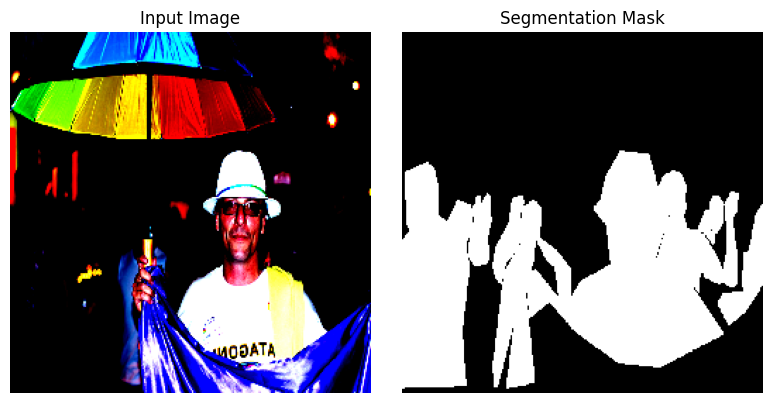

In [ ]:
# 5. Visual Inspection of Masks
for i in random.sample(range(len(train_ds)), 3):
    img, mask = train_ds[i]
    img_np = np.transpose(img.numpy(), (1, 2, 0)).clip(0, 1)
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1); plt.imshow(img_np); plt.title("Input Image"); plt.axis('off')
    plt.subplot(1, 2, 2); plt.imshow(mask[0], cmap='gray'); plt.title("Segmentation Mask"); plt.axis('off')
    plt.tight_layout(); plt.show()

/tmp/ipython-input-10-2606131528.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([heights, widths], labels=['Height', 'Width'], patch_artist=True)


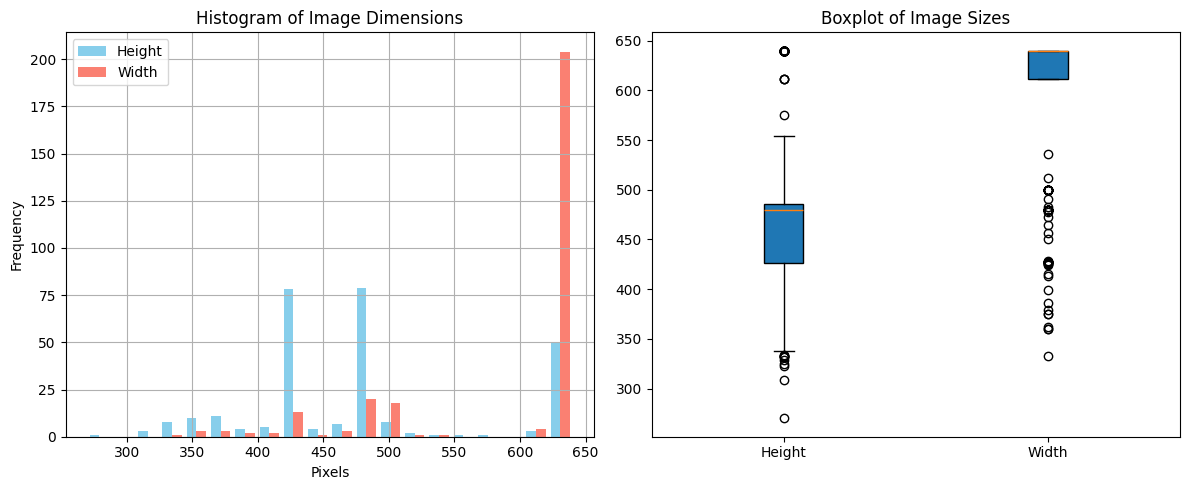

In [10]:
# 6. Image Dimension Statistics
image_dims = [(train_ds.coco.loadImgs(img_id)[0]['height'], train_ds.coco.loadImgs(img_id)[0]['width']) for img_id in train_ds.img_ids]
heights, widths = zip(*image_dims)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist([heights, widths], bins=20, label=['Height', 'Width'], color=['skyblue', 'salmon'])
plt.title("Histogram of Image Dimensions")
plt.xlabel("Pixels"); plt.ylabel("Frequency"); plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.boxplot([heights, widths], labels=['Height', 'Width'], patch_artist=True)
plt.title("Boxplot of Image Sizes")
plt.tight_layout(); plt.show()

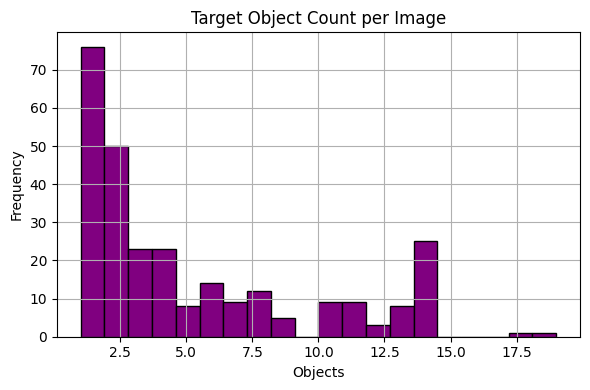

In [28]:
# 7. Object Count per Image
ann_counts = [len(train_ds.coco.getAnnIds(imgIds=img_id, catIds=train_ds.target_ids)) for img_id in train_ds.img_ids]
plt.figure(figsize=(6, 4))
plt.hist(ann_counts, bins=20, color='purple', edgecolor='black')
plt.title("Target Object Count per Image")
plt.xlabel("Objects"); plt.ylabel("Frequency"); plt.grid(True)
plt.tight_layout(); plt.show()

# 8. Initialize DeepLabV3+ Model
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = smp.DeepLabV3Plus(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1
).to(DEVICE)

In [29]:
# 9. Loss and Optimizer Setup
import torch.nn as nn
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 10. Training and Validation Function
def train_or_val(loader, train=False):
    model.train() if train else model.eval()
    total_loss = 0
    for img, mask in loader:
        img, mask = img.to(DEVICE), mask.to(DEVICE)
        if train: optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            out = model(img)
            out = out[:, 0:1]
            loss = criterion(out, mask)
            if train:
                loss.backward(); optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [ ]:
# 11. Training Loop
train_losses, val_losses = [], []
for epoch in range(10):
    tr_loss = train_or_val(train_loader, train=True)
    vl_loss = train_or_val(val_loader)
    train_losses.append(tr_loss)
    val_losses.append(vl_loss)
    print(f"Epoch {epoch+1}/10 | Train: {tr_loss:.4f} | Val: {vl_loss:.4f}")

In [ ]:
# 12. Plot Loss Progression
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

In [21]:
# 13. IOU and Dice Metrics
def iou_dice(pred, true):
    pred_bin, true_bin = pred > 0.5, true > 0.5
    inter = (pred_bin & true_bin).sum()
    union = (pred_bin | true_bin).sum()
    dice = 2 * inter / (pred_bin.sum() + true_bin.sum() + 1e-8)
    iou = inter / (union + 1e-8)
    return float(iou), float(dice)

Sample 94 — IoU: 0.000, Dice: 0.000


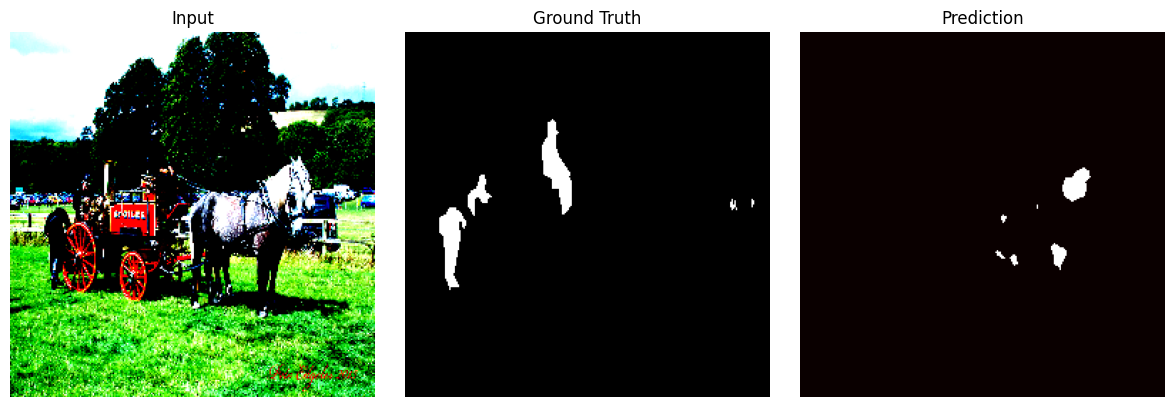

Sample 63 — IoU: 0.188, Dice: 0.316


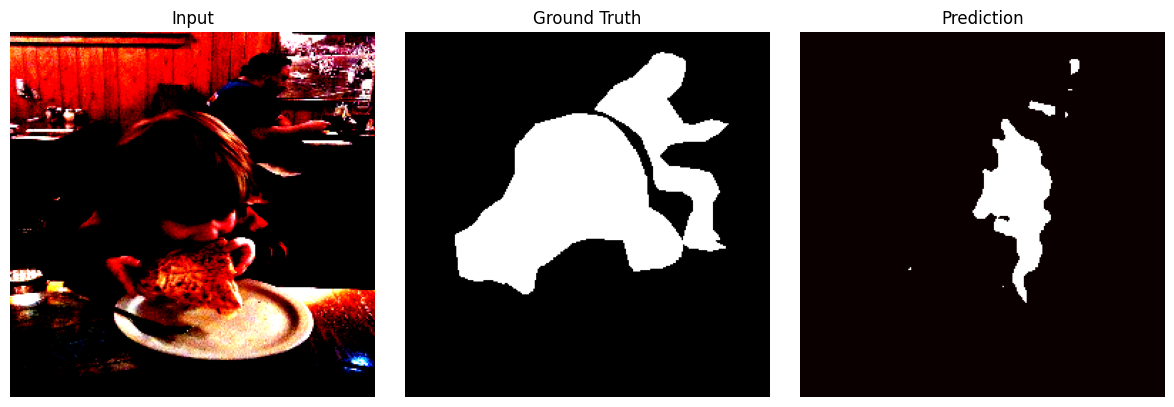

Sample 174 — IoU: 0.130, Dice: 0.230


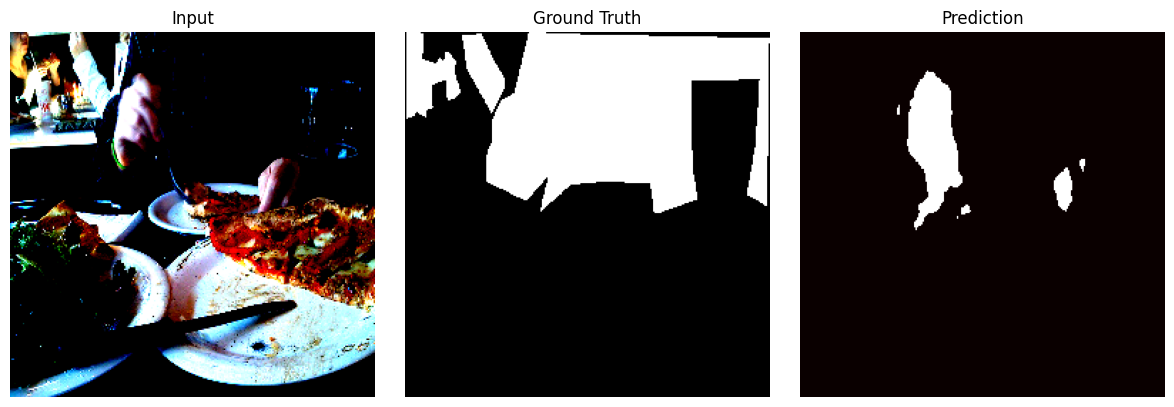


Predictions on Sample Test Images:


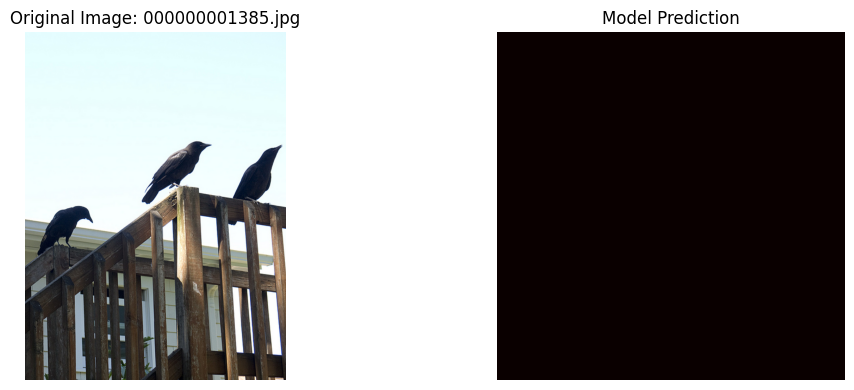

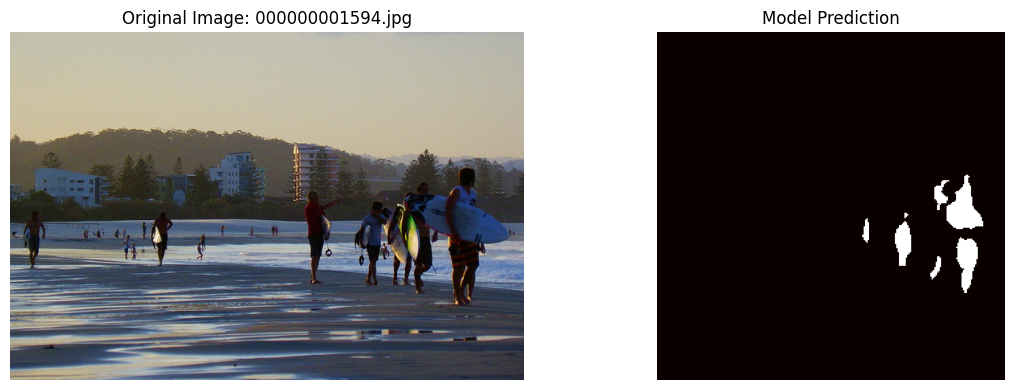

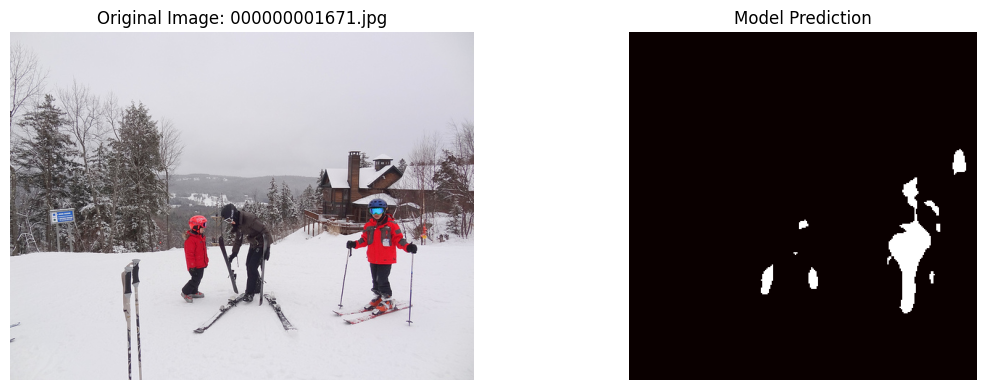

In [22]:

# 14. Evaluate on Validation Set
model.eval()
for idx in random.sample(range(len(val_ds)), 3):
    img, mask = val_ds[idx]
    with torch.no_grad():
        pred = torch.sigmoid(model(img.unsqueeze(0).to(DEVICE)))[0, 0].cpu().numpy()
    iou, dice = iou_dice(pred, mask[0].numpy())
    print(f"Sample {idx} — IoU: {iou:.3f}, Dice: {dice:.3f}")
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(np.transpose(img.numpy(), (1, 2, 0)).clip(0, 1)); axs[0].set_title("Input")
    axs[1].imshow(mask[0], cmap='gray'); axs[1].set_title("Ground Truth")
    axs[2].imshow(pred > 0.5, cmap='hot'); axs[2].set_title("Prediction")
    for a in axs: a.axis('off')
    plt.tight_layout(); plt.show()

# 15. Run Inference on Test Images
print("\nPredictions on Sample Test Images:")
model.eval()
for idx in random.sample(range(len(test_ds)), 3):
    img, orig_img, fname = test_ds[idx]
    with torch.no_grad():
        pred = torch.sigmoid(model(img.unsqueeze(0).to(DEVICE)))[0, 0].cpu().numpy()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(orig_img.astype(np.uint8))
    plt.title(f"Original Image: {fname}"); plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pred > 0.5, cmap='hot')
    plt.title("Model Prediction"); plt.axis('off')
    plt.tight_layout(); plt.show()



Validation Predictions with Ground Truth:


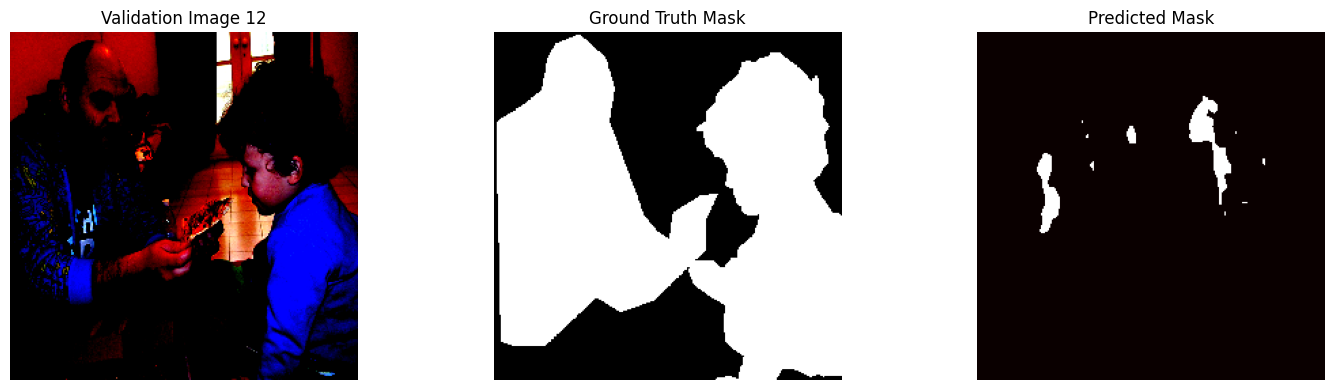

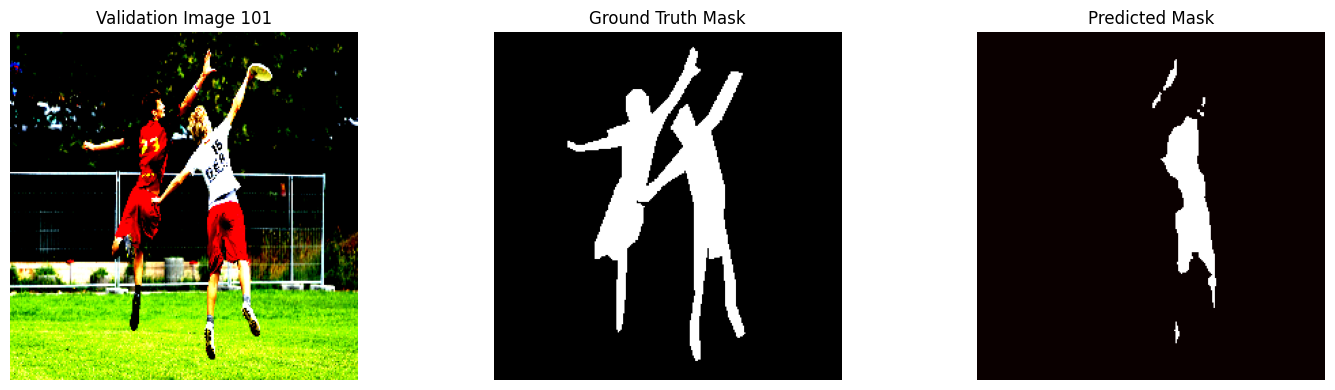

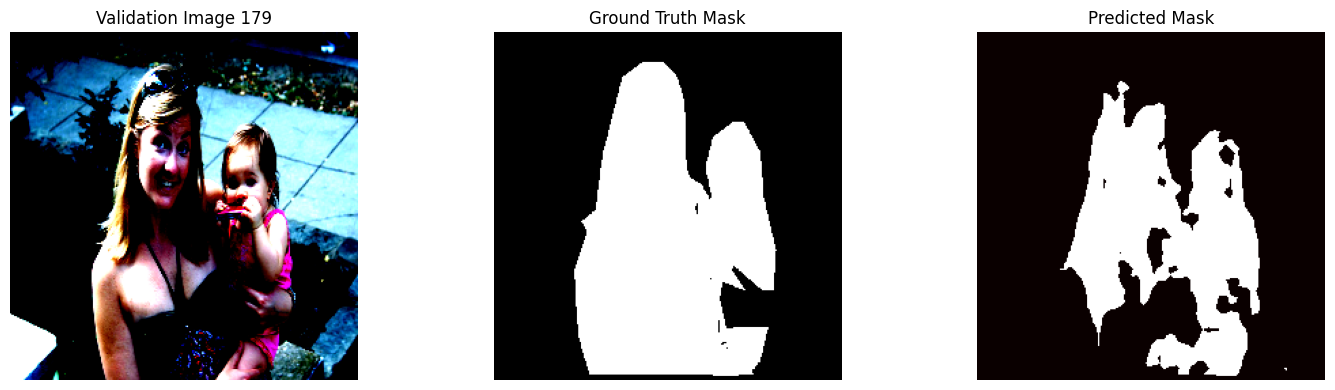

In [23]:
# 15. Inference on Random Validation Images with Ground Truth and Prediction
print("\nValidation Predictions with Ground Truth:")
model.eval()
random_indices = random.sample(range(len(val_ds)), 3)

for idx in random_indices:
    img, mask = val_ds[idx]

    with torch.no_grad():
        pred = torch.sigmoid(model(img.unsqueeze(0).to(DEVICE)))[0, 0].cpu().numpy()

    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)).clip(0, 1))
    plt.title(f"Validation Image {idx}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask[0], cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred > 0.5, cmap='hot')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
